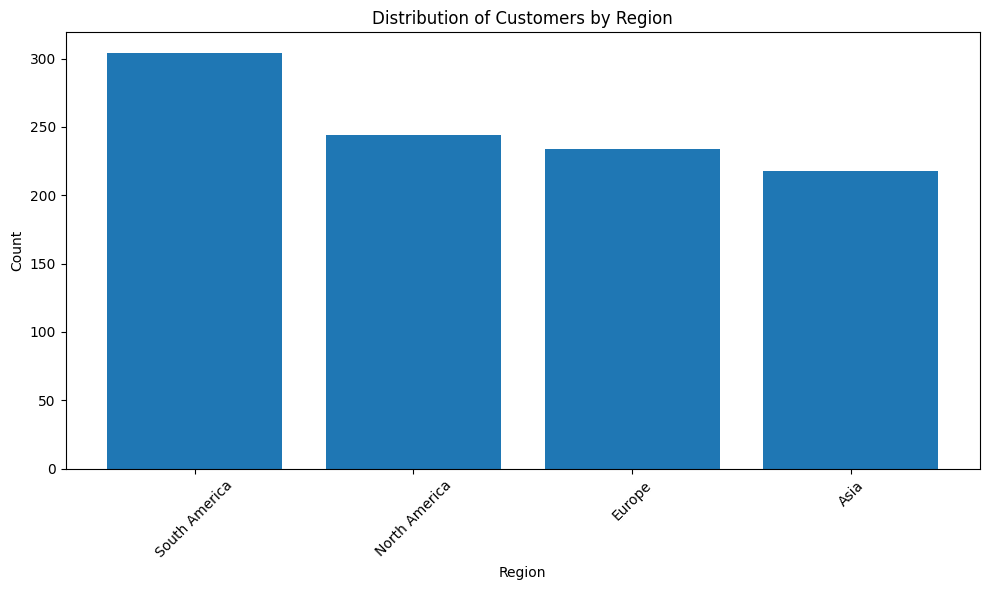

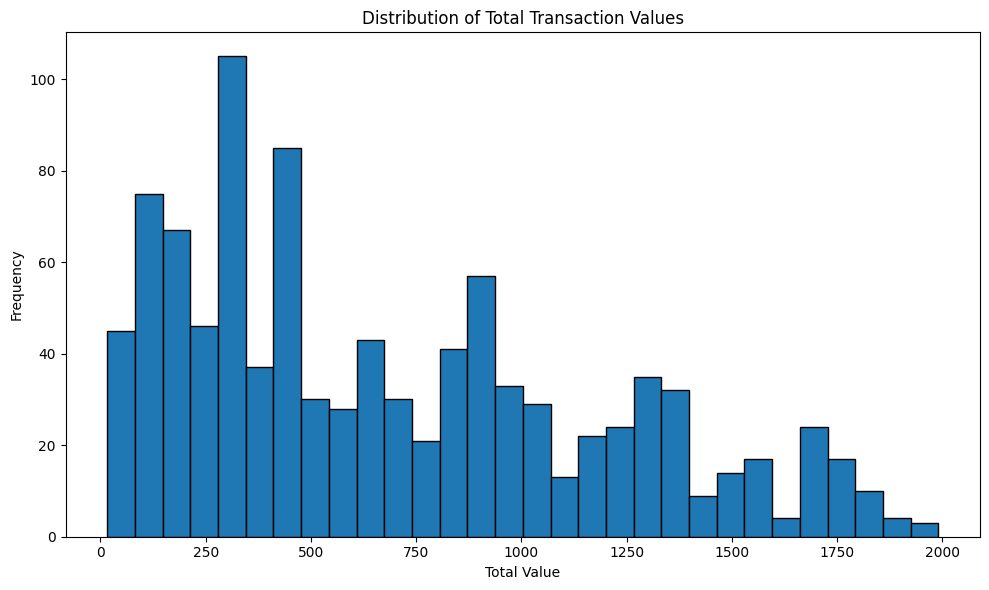

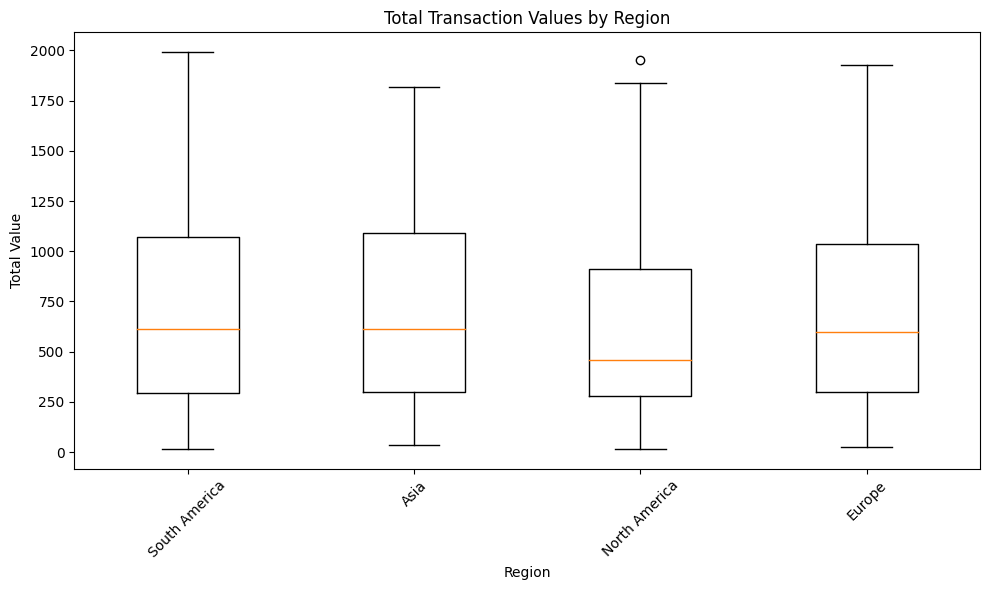

Davies-Bouldin Index: 0.8827408814201491
Silhouette Score: 0.4146415447378831


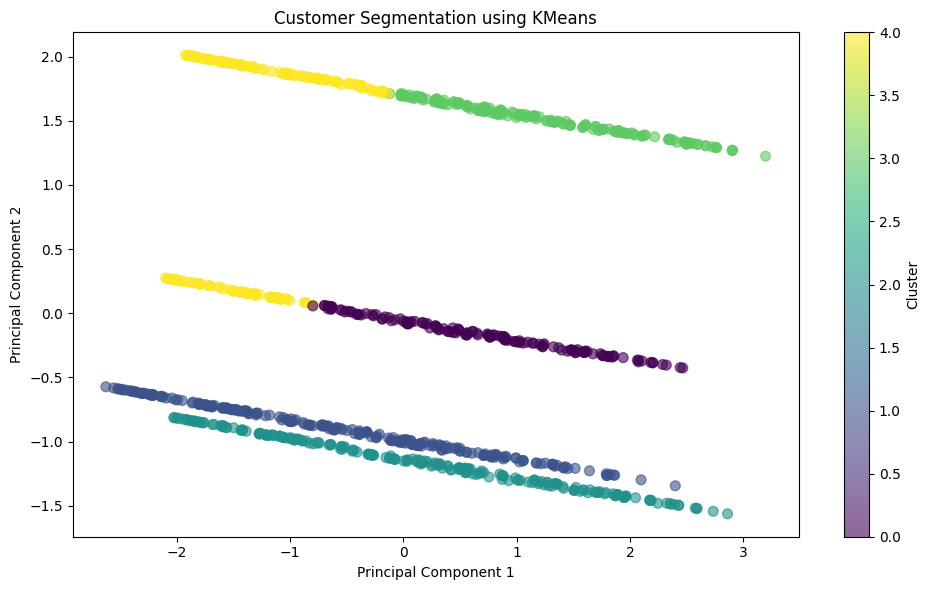


Cluster Analysis:
        TotalValue                 Price                 Region
              mean count  median    mean  median       <lambda>
Cluster                                                        
0           927.16   147  916.24  350.38  372.55           Asia
1           624.24   244  456.92  265.24  281.24  North America
2           710.49   234  596.58  275.57  300.68         Europe
3          1019.91   185  958.80  377.59  396.34  South America
4           244.48   190  197.22  115.75  126.34  South America


In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Step 2: Load datasets
customers = pd.read_csv('/kaggle/input/company-dataset/Customers.csv')
products = pd.read_csv('/kaggle/input/company-dataset/Products.csv')
transactions = pd.read_csv('/kaggle/input/company-dataset/Transactions.csv')

# Step 3: Merge datasets based on 'CustomerID'
merged_data = pd.merge(customers[['CustomerID', 'CustomerName', 'Region']], 
                      transactions, 
                      on='CustomerID', 
                      how='inner')

# Step 4: Data preprocessing
def safe_numeric_convert(series):
    numeric_series = pd.to_numeric(series, errors='coerce')
    return numeric_series.replace([np.inf, -np.inf], np.nan)

merged_data['TotalValue'] = safe_numeric_convert(merged_data['TotalValue'])
merged_data['Price'] = safe_numeric_convert(merged_data['Price'])

# Handle missing values
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    merged_data[col] = merged_data[col].fillna(merged_data[col].median())

non_numeric_cols = merged_data.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_cols:
    merged_data[col] = merged_data[col].fillna(merged_data[col].mode()[0])

# Step 5: Visualizations
# 1. Customer Distribution by Region
plt.figure(figsize=(10, 6))
region_counts = merged_data['Region'].value_counts()
plt.bar(region_counts.index, region_counts.values)
plt.title('Distribution of Customers by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Total Value Distribution
plt.figure(figsize=(10, 6))
valid_values = merged_data[merged_data['TotalValue'].notna() & merged_data['TotalValue'].abs().ne(np.inf)]
plt.hist(valid_values['TotalValue'], bins=30, edgecolor='black')
plt.title('Distribution of Total Transaction Values')
plt.xlabel('Total Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. Box Plot
plt.figure(figsize=(10, 6))
regions = valid_values['Region'].unique()
data_to_plot = [valid_values[valid_values['Region'] == region]['TotalValue'] for region in regions]
plt.boxplot(data_to_plot, labels=regions)
plt.title('Total Transaction Values by Region')
plt.xlabel('Region')
plt.ylabel('Total Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 6: Clustering
# Prepare features
merged_data_encoded = pd.get_dummies(merged_data, columns=['Region'], drop_first=True)
features_for_clustering = ['TotalValue', 'Price'] + [col for col in merged_data_encoded.columns if 'Region_' in col]

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data_encoded[features_for_clustering])

# Apply KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(scaled_data)
merged_data['Cluster'] = kmeans.labels_

# Evaluation metrics
db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
sil_score = silhouette_score(scaled_data, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {sil_score}')

# Visualize clusters
pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], 
                     c=merged_data['Cluster'], 
                     cmap='viridis', 
                     s=50, 
                     alpha=0.6)
plt.title('Customer Segmentation using KMeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Cluster analysis
print("\nCluster Analysis:")
cluster_summary = merged_data.groupby('Cluster').agg({
    'TotalValue': ['mean', 'count', 'median'],
    'Price': ['mean', 'median'],
    'Region': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown'
}).round(2)

print(cluster_summary)
